In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import * 
from core.DiT_model_lib import *
from core.dataset_lib import load_dataset
from circuit_toolkit.plot_utils import saveallforms, to_imgrid
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [11]:
ffhq_Xtsr, imgsize = load_dataset("ffhq-32x32")

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


In [13]:
DiT_model = DiT(input_size=32,
                patch_size=2,
                in_channels=3,
                hidden_size=192,
                depth=6,
                num_heads=3,
                mlp_ratio=4.0,
                class_dropout_prob=0.1,
                num_classes=0,
                learn_sigma=False,)

In [36]:
DiT_model

DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=192, bias=True)
      (1): SiLU()
      (2): Linear(in_features=192, out_features=192, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1, 192)
  )
  (blocks): ModuleList(
    (0-5): 6 x DiTBlock(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=

In [20]:
device = get_device()
z = torch.randn(5, 3, 32, 32).to(device)
t = torch.rand(5,).float().to(device)
y = torch.zeros(5,).long().to(device)
DiT_model.train().to(device)
with torch.no_grad():
    out = DiT_model(z, t, y)
    print(out.shape)


torch.Size([5, 3, 32, 32])


In [21]:
from core.diffusion_edm_lib import EDMCNNPrecondWrapper

In [29]:
class EDMDiTPrecondWrapper(nn.Module):
    def __init__(self, model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        if cond is None:
            cond = torch.zeros(X.shape[0],).long().to(X.device)
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        model_out = self.model(c_in * X, c_noise.view(-1), y=cond) # this is required for EDM Unet model. 
        return c_skip * X + c_out * model_out

In [23]:
DiT_model = DiT(input_size=32,
                patch_size=2,
                in_channels=3,
                hidden_size=192,
                depth=6,
                num_heads=3,
                mlp_ratio=4.0,
                class_dropout_prob=0.1,
                num_classes=0,
                learn_sigma=False,)

In [24]:
device = get_device()
Xtsr = (ffhq_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
# pnts = (pnts - 0.5) / 0.5
# cov_empirical = torch.cov(pnts.T, correction=1)
ndim = pnts.shape[1]
imgshape = Xtsr.shape[1:]

In [33]:
device = "cuda"
lr = 0.0001
nsteps = 5000
batch_size = 256
record_frequency = 0
record_times = []
sampling_callback_fn = None
# unet = create_unet_model(config)
model_precd = EDMDiTPrecondWrapper(DiT_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times)


# # pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
# pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
# torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")


noise_init = torch.randn(64, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
mtg = to_imgrid(((x_out.cpu()[:64]+1)/2).clamp(0, 1), nrow=8, padding=1)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 0.838


KeyboardInterrupt: 

In [34]:
noise_init = torch.randn(64, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
mtg = to_imgrid(((x_out.cpu()[:64]+1)/2).clamp(0, 1), nrow=8, padding=1)


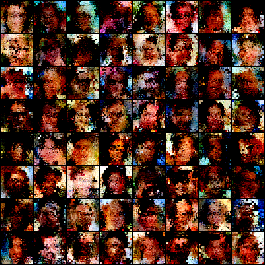

In [35]:
mtg

In [ ]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
Xtsr = (ffhq_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
# pnts = (pnts - 0.5) / 0.5
# cov_empirical = torch.cov(pnts.T, correction=1)
ndim = pnts.shape[1]
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=8, nhidden=1024, time_embed_dim=128,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=100000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()